In [139]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["axes.unicode_minus"]=False 

In [140]:
data=pd.read_csv('./use.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1314)
feature=train_data.drop(['Sel','Unnamed: 0'],axis=1)
label=train_data['Sel']

In [141]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [142]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,25,1)
    lambda_l2=trial.suggest_float("lambda_l2",1,4)
    subsample=trial.suggest_float('subsample',0.3,0.9)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.2,0.8)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.4)
    reg=lgb.LGBMRegressor(iterations=iterations,
                             max_depth=max_depth,
                             lambda_l2=lambda_l2,
                             subsample=subsample,
                             colsample_bytree=colsample_bytree,
                             learning_rate=learning_rate,
                             verbose=-1
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [143]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [144]:
optimizer_optuna(250)

[I 2023-04-27 13:49:40,520] A new study created in memory with name: no-name-f3d5e3cd-c5c3-4a78-8164-3d3222cd0f37
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-04-27 13:49:40,746] Trial 0 finished with value: 0.843030130786963 and parameters: {'iterations': 780, 'max_depth': 8, 'lambda_l2': 1.4687963967104953, 'subsample': 0.8483687373504261, 'colsample_bytree': 0.6333805526074971, 'learning_rate': 0.33108239406316464}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:40,866] Trial 1 finished with value: 0.8162143243252254 and parameters: {'iterations': 690, 'max_depth': 19, 'lambda_l2': 3.3474680401593013, 'subsample': 0.6758989430852707, 'colsample_bytree': 0.2438862452998737, 'learning_rate': 0.23837746250285807}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:41,025] Trial 2 finished with value: 0.8396833841013811 and parameters: {'iterations': 1000, 'max_depth': 25, 'lambda_l2': 1.9785585199031055, 'subsample': 0.6205393878153505, 'colsample_bytree': 0.6541354503057556, 'learning_rate': 0.1574231753058492}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:41,154] Trial 3 fin

({'iterations': 480,
  'max_depth': 12,
  'lambda_l2': 3.3623304292402914,
  'subsample': 0.7392826642697368,
  'colsample_bytree': 0.7705855922151122,
  'learning_rate': 0.2852076993094798},
 [0.861843365437098])

In [172]:
model = lgb.LGBMRegressor(random_state=1314,iterations=500,verbose=-1,
                        #   max_depth=21,
                        #   colsample_bytree=0.6996018516903802,subsample=0.360500873673603,
                          lambda_l2=3.6696821767896,learning_rate= 0.4135020975900916).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6929272921925503
rmse: 11.84759079228258


In [174]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Sel','Unnamed: 0'],axis=1)
test_y = test_data['Sel']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9747207056520663
MAE: 3.47173807548856
测试集得分为： 0.8025041386135378 9.525400510193586


In [147]:
# 预测1
Y1=model.predict(test_data.drop(['Sel','Unnamed: 0'],axis=1))
Y2=test_data['Sel']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [148]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

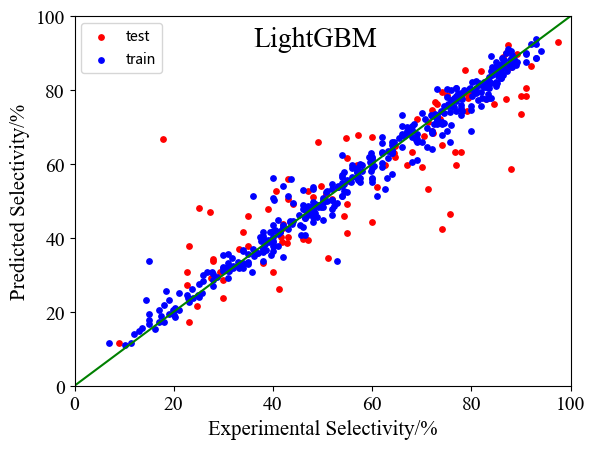

In [177]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(36,92,'LightGBM',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

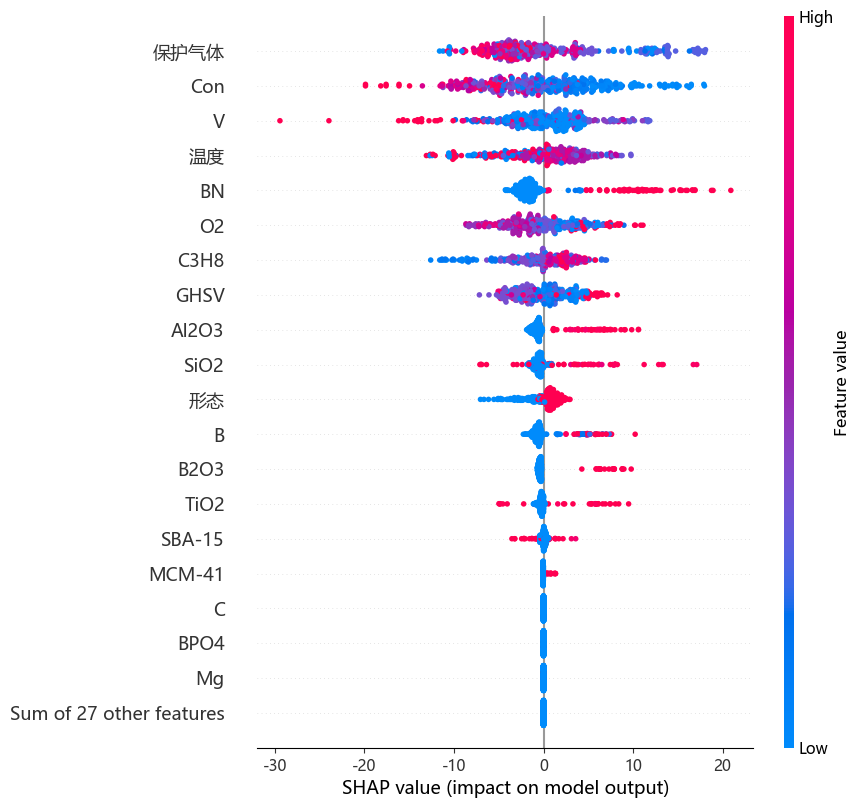

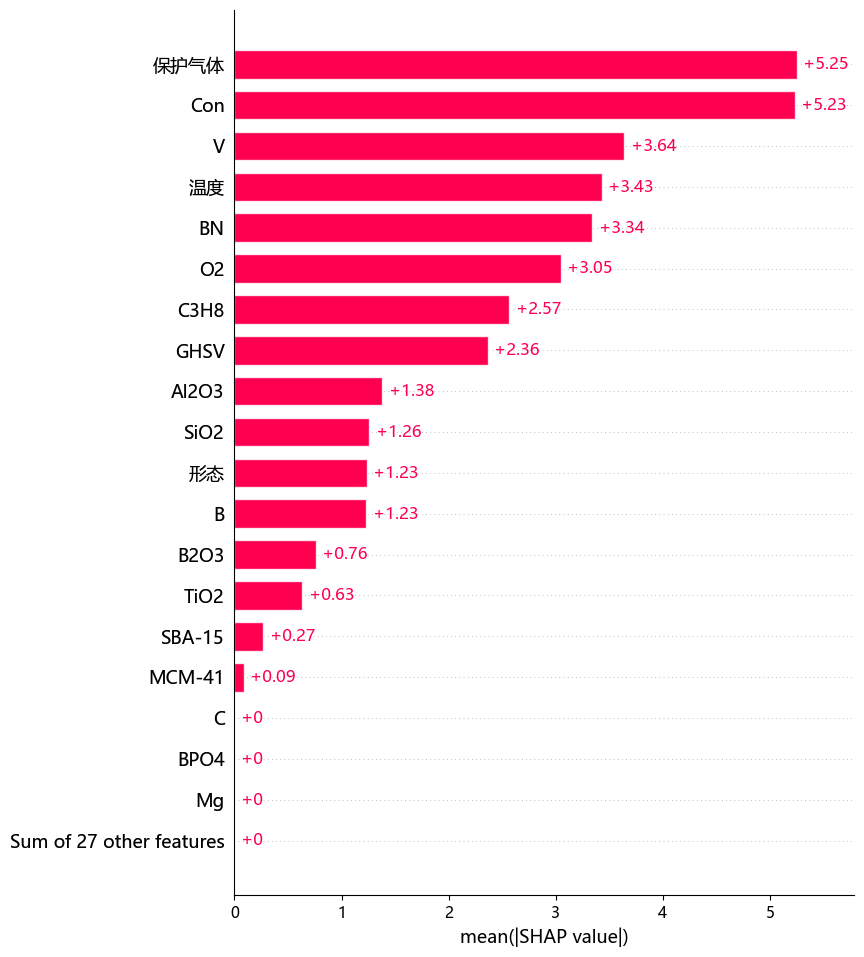

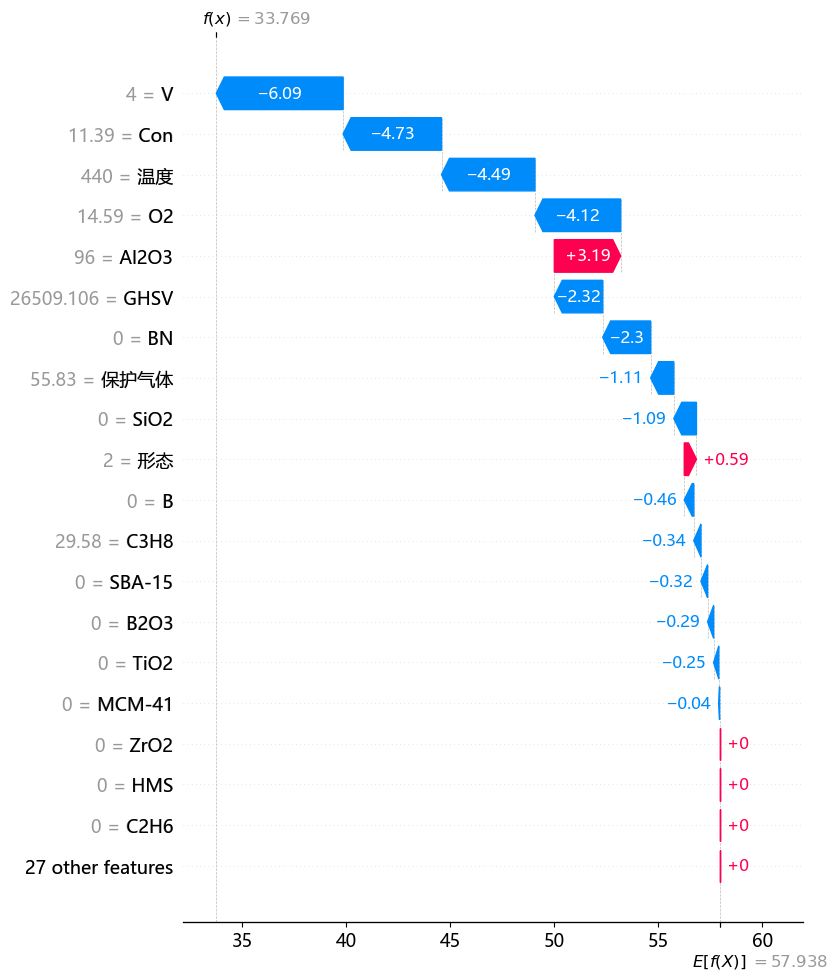

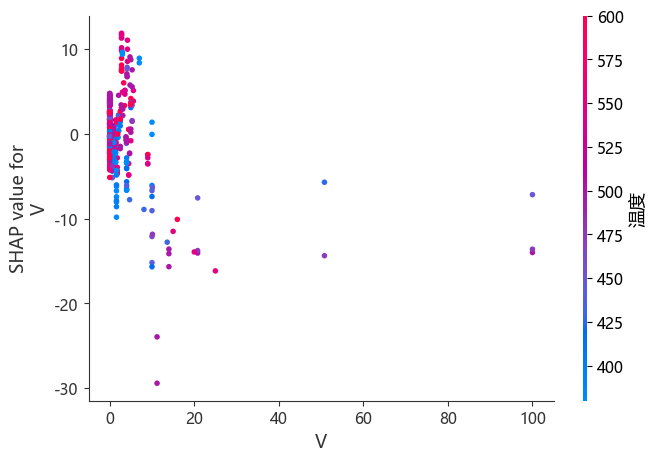

In [180]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)
shap.plots.waterfall(shap_values[0], max_display=20)
shap.plots.force(shap_values[0])
shap.force_plot(explainer.expected_value, shap_values.values, feature)
shap.dependence_plot("V", shap_values.values, feature, interaction_index='温度')

In [179]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.3617 ± 0.0729,V
0.3385 ± 0.0908,Con
0.2886 ± 0.0641,保护气体
0.1847 ± 0.0701,O2
0.1823 ± 0.0926,温度
0.1169 ± 0.0183,C3H8
0.1024 ± 0.0451,BN
0.0866 ± 0.0261,Al2O3
0.0642 ± 0.0277,SiO2
0.0443 ± 0.0354,GHSV
